# Multi-label Text Classification with SciBERT and PyTorch Lightning

Adapted from: https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/

* Changed optimization parameter from AUROC to Average Precision.
* Changed the dataset to the biomimicry dataset.
* Changed method of splitting the data into train and val datasets to use a multi-label stratification method to maintain class distributions in the two splits.
* Changed BERT model and tokenizer to SciBERT
* Added AP, MAP, and gMAP prediction output

> TL;DR Learn how to prepare a dataset with biomimicry papers for multi-label text classification (tagging). We'll fine-tune SciBERT using PyTorch Lightning and evaluate the model.

Multi-label text classification (or tagging text) is one of the most common tasks you'll encounter when doing NLP. Modern Transformer-based models (like BERT) make use of pre-training on vast amounts of text data that makes fine-tuning faster, use fewer resources and more accurate on small(er) datasets.

In this tutorial, you'll learn how to:

- Load, balance and split text data into sets
- Tokenize text (with BERT tokenizer) and create PyTorch dataset
- Fine-tune BERT model with PyTorch Lightning
- Find out about warmup steps and use a learning rate scheduler
- Use Average Precision and binary cross-entropy to evaluate the model during training
- How to make predictions using the fine-tuned BERT model
- Evaluate the performance of the model for each class (possible comment tag)

Will our model be any good for biomimicry function detection?

- [Read the original tutorial](https://curiousily.com/posts/multi-label-text-classification-with-bert-and-pytorch-lightning/)
- [Run the original notebook in your browser (Google Colab)](https://colab.research.google.com/drive/14Ea4lIzsn5EFvPpYKtWStXEByT9qmbkj?usp=sharing)
- [Read the *Getting Things Done with Pytorch* book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

In [ ]:
!nvidia-smi

Thu Dec  9 16:17:05 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P8    26W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#!pip install pytorch-lightning==1.2.8 --quiet
#!pip install transformers==4.5.1 --quiet

!pip install pytorch-lightning --quiet
!pip install transformers --quiet
!pip install torchmetrics
!pip install scikit-multilearn

     |████████████████████████████████| 525 kB 2.2 MB/s 
     |████████████████████████████████| 332 kB 40.2 MB/s 
     |████████████████████████████████| 132 kB 43.4 MB/s 
     |████████████████████████████████| 829 kB 26.4 MB/s 
     |████████████████████████████████| 596 kB 35.5 MB/s 
     |████████████████████████████████| 1.1 MB 36.6 MB/s 
     |████████████████████████████████| 192 kB 48.3 MB/s 
     |████████████████████████████████| 271 kB 43.4 MB/s 
     |████████████████████████████████| 160 kB 46.3 MB/s 
     |████████████████████████████████| 3.3 MB 2.3 MB/s 
     |████████████████████████████████| 61 kB 467 kB/s 
     |████████████████████████████████| 3.3 MB 31.4 MB/s 
     |████████████████████████████████| 895 kB 47.0 MB/s 
     |████████████████████████████████| 89 kB 2.3 MB/s 


In [ ]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.functional import accuracy, f1, auroc, precision_recall_curve, average_precision
#from pytorch_lightning.metrics.functional import accuracy, f1, auroc
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

%matplotlib inline
%config InlineBackend.figure_format='retina'

RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Global seed set to 42


42

## Data

Let's load and look at the data:

In [ ]:
# Read in the cleaned data
data_prefix = 'https://raw.githubusercontent.com/nasa-petal/search-engine/main/data/'
df = pd.read_csv(data_prefix + 'cleaned.csv')

# Drop all non-feature columns
non_feat = ['y', 'text']
df.drop(non_feat, axis=1, inplace=True)
df.head()

,physically_assemble_or_disassemble,protect_from_harm,sense_send_or_process_information,chemically_modify_or_change_energy_state,maintain_structural_integrity,attach,move,process_resources,sustain_ecological_community,change_size_or_color,text_raw
0,1,1,0,0,0,0,0,0,0,0,Building a home from foam—túngara frog foam ne...
1,0,0,1,0,0,0,0,0,0,0,"A nocturnal mammal, the greater mouse-eared ba..."
2,0,0,1,0,0,0,0,0,0,0,Polarization sensitivity in two species of cut...
3,0,1,0,1,0,0,0,0,0,0,Identification and characterization of a multi...
4,0,0,0,0,1,0,0,0,0,0,DIFFERENCES IN POLYSACCHARIDE STRUCTURE BETWEE...


We have text (raw title and abstract) and ten different level 1 biomimicry labels.

Let's split the data:

In [ ]:
from skmultilearn.model_selection import iterative_train_test_split

def iterative_train_test_split_dataframe(X, y, test_size):
    df_index = np.expand_dims(X.index.to_numpy(), axis=1)
    df_index_y = np.expand_dims(y.index.to_numpy(), axis=1)
    X_train, y_train, X_test, y_test = iterative_train_test_split(df_index, df_index_y, test_size = test_size)
    X_train = X.loc[X_train[:,0]]
    X_test = X.loc[X_test[:,0]]
    y_train = y.loc[y_train[:,0]]
    y_test = y.loc[y_test[:,0]]
    return X_train, y_train, X_test, y_test

LABEL_COLUMNS = df.columns.tolist()[:-1]

X_train, y_train, X_test, y_test = iterative_train_test_split_dataframe(X=df[['text_raw']], y=df[LABEL_COLUMNS], test_size = 0.1)
train_df = pd.concat([X_train, y_train], axis=1)
val_df = pd.concat([X_test, y_test], axis=1)
#train_df, val_df = train_test_split(df, test_size=0.1)
train_df.shape, val_df.shape

((960, 11), (107, 11))

## Preprocessing

Let's look at the distribution of the labels in the original datset, and the train and val splits:

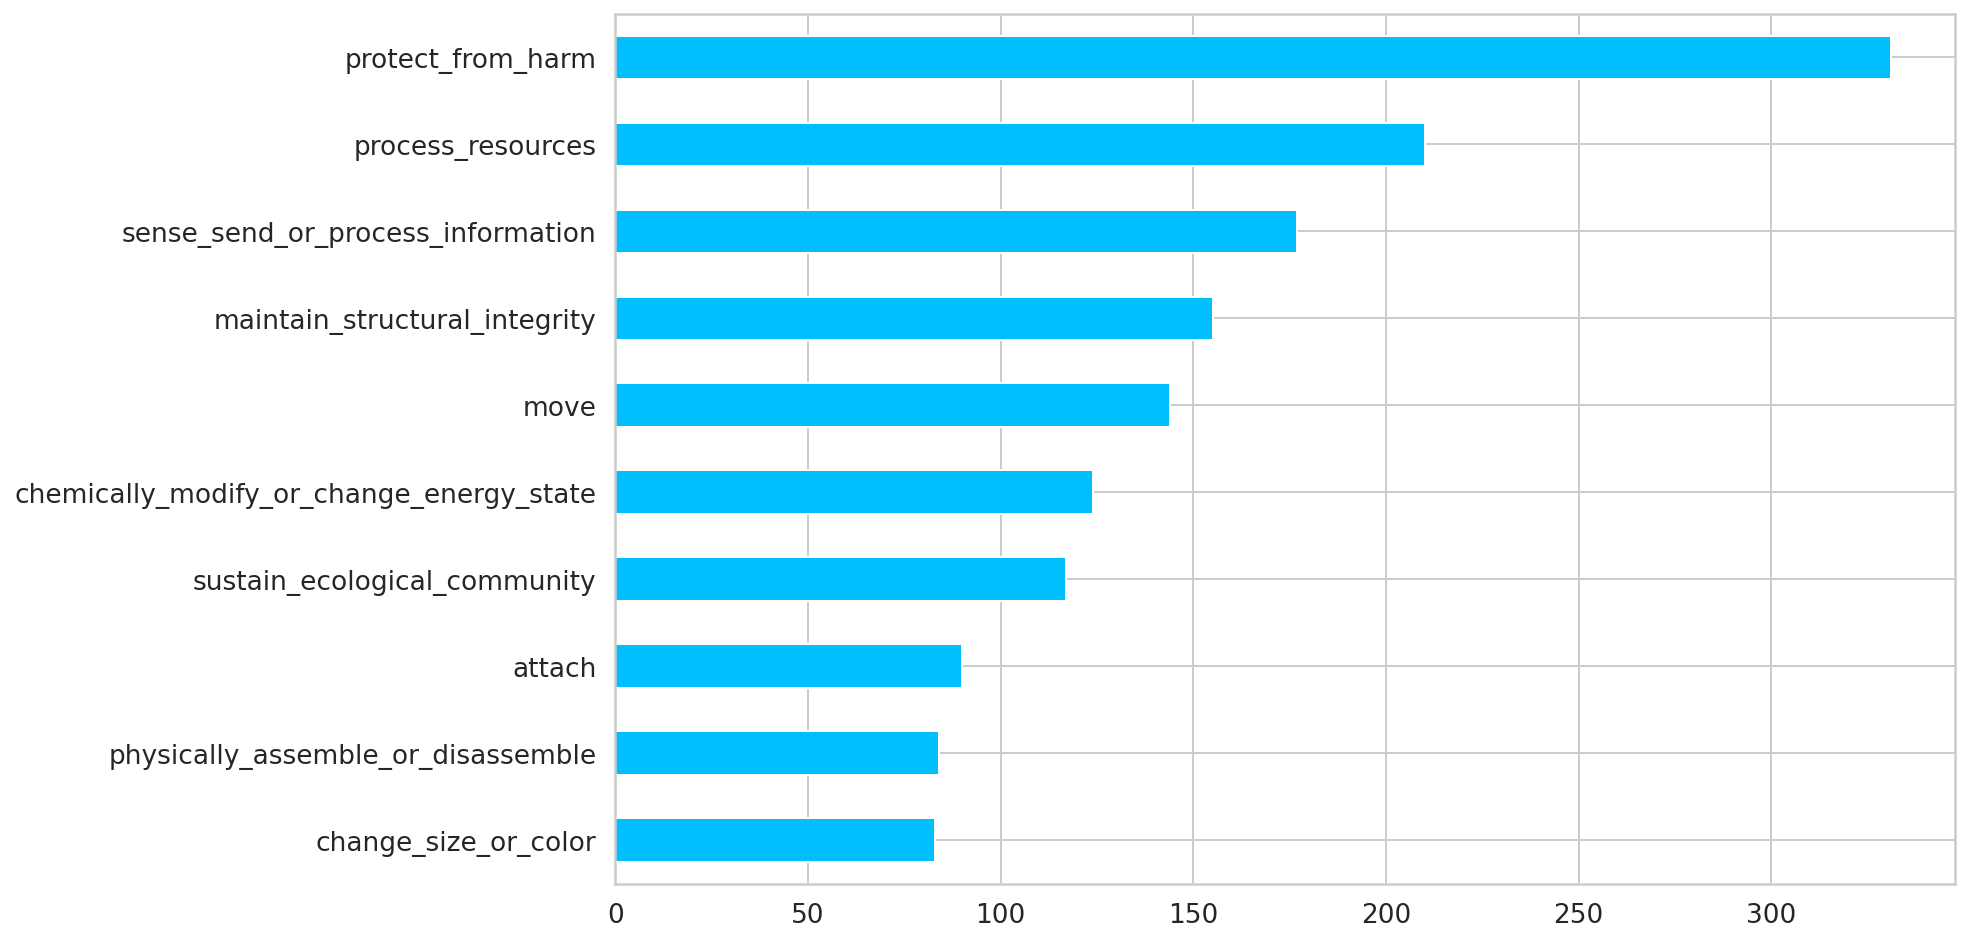

In [ ]:
df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

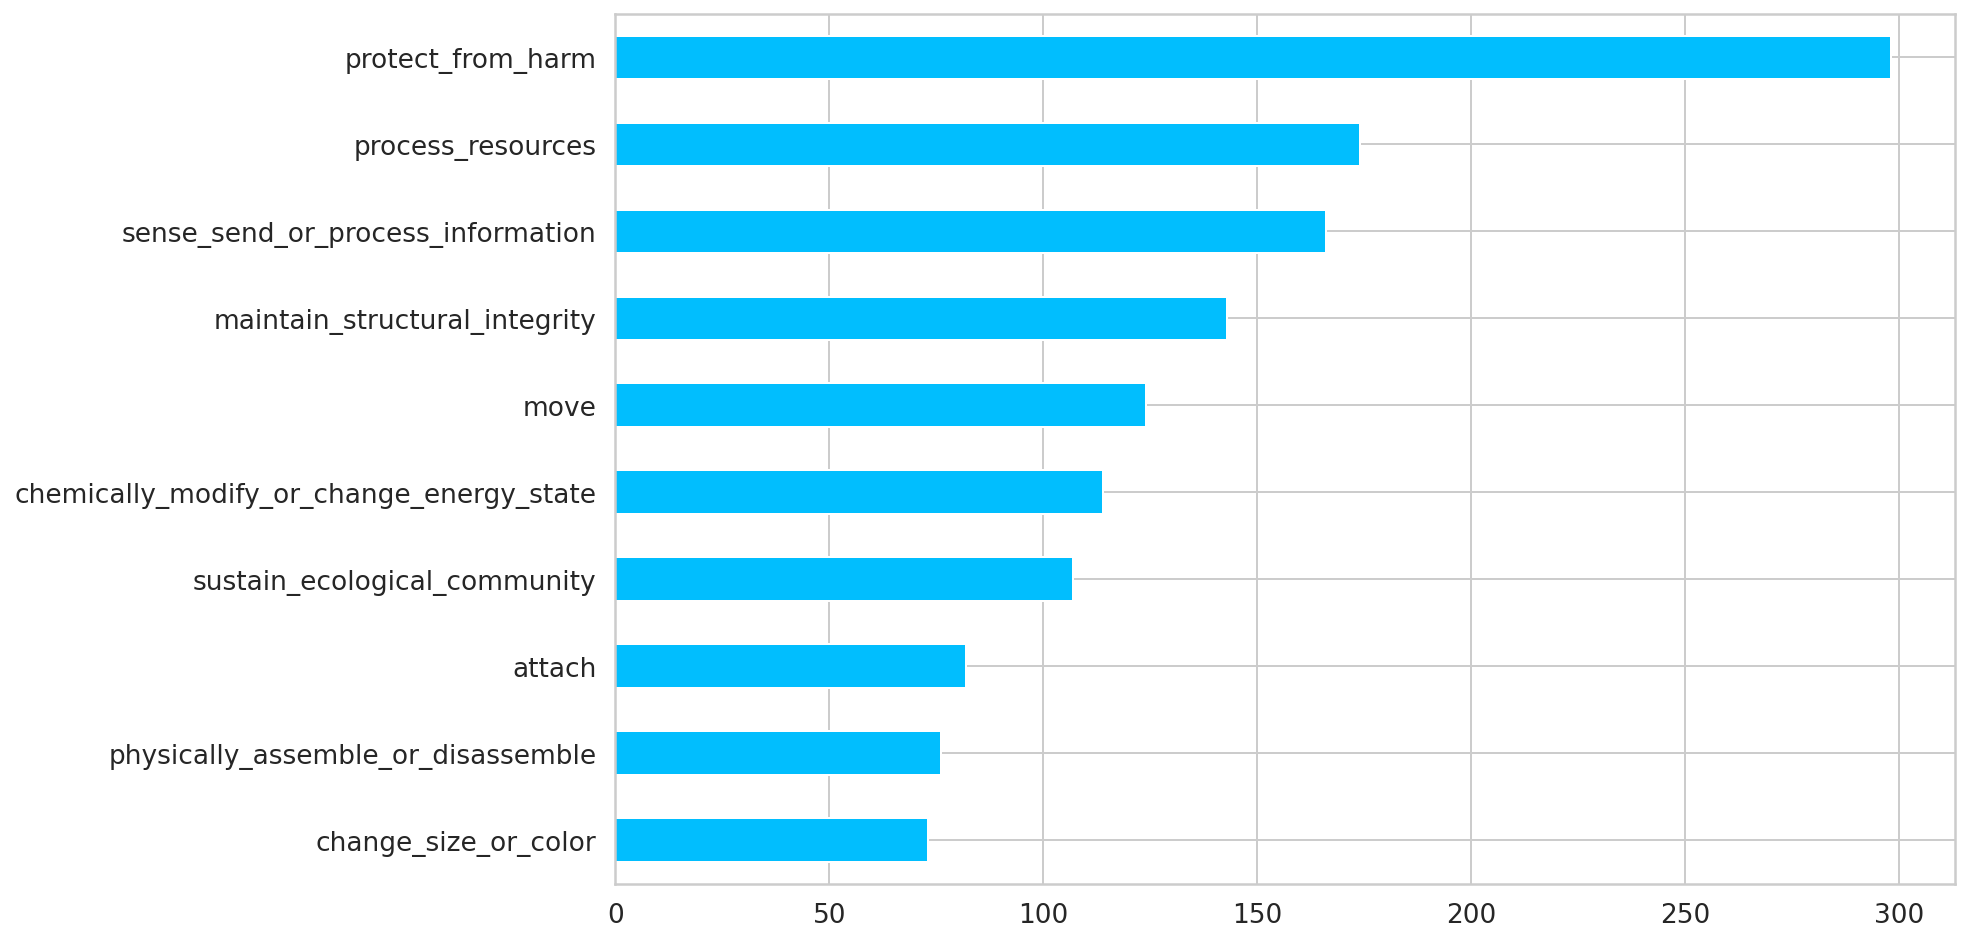

In [ ]:
train_df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

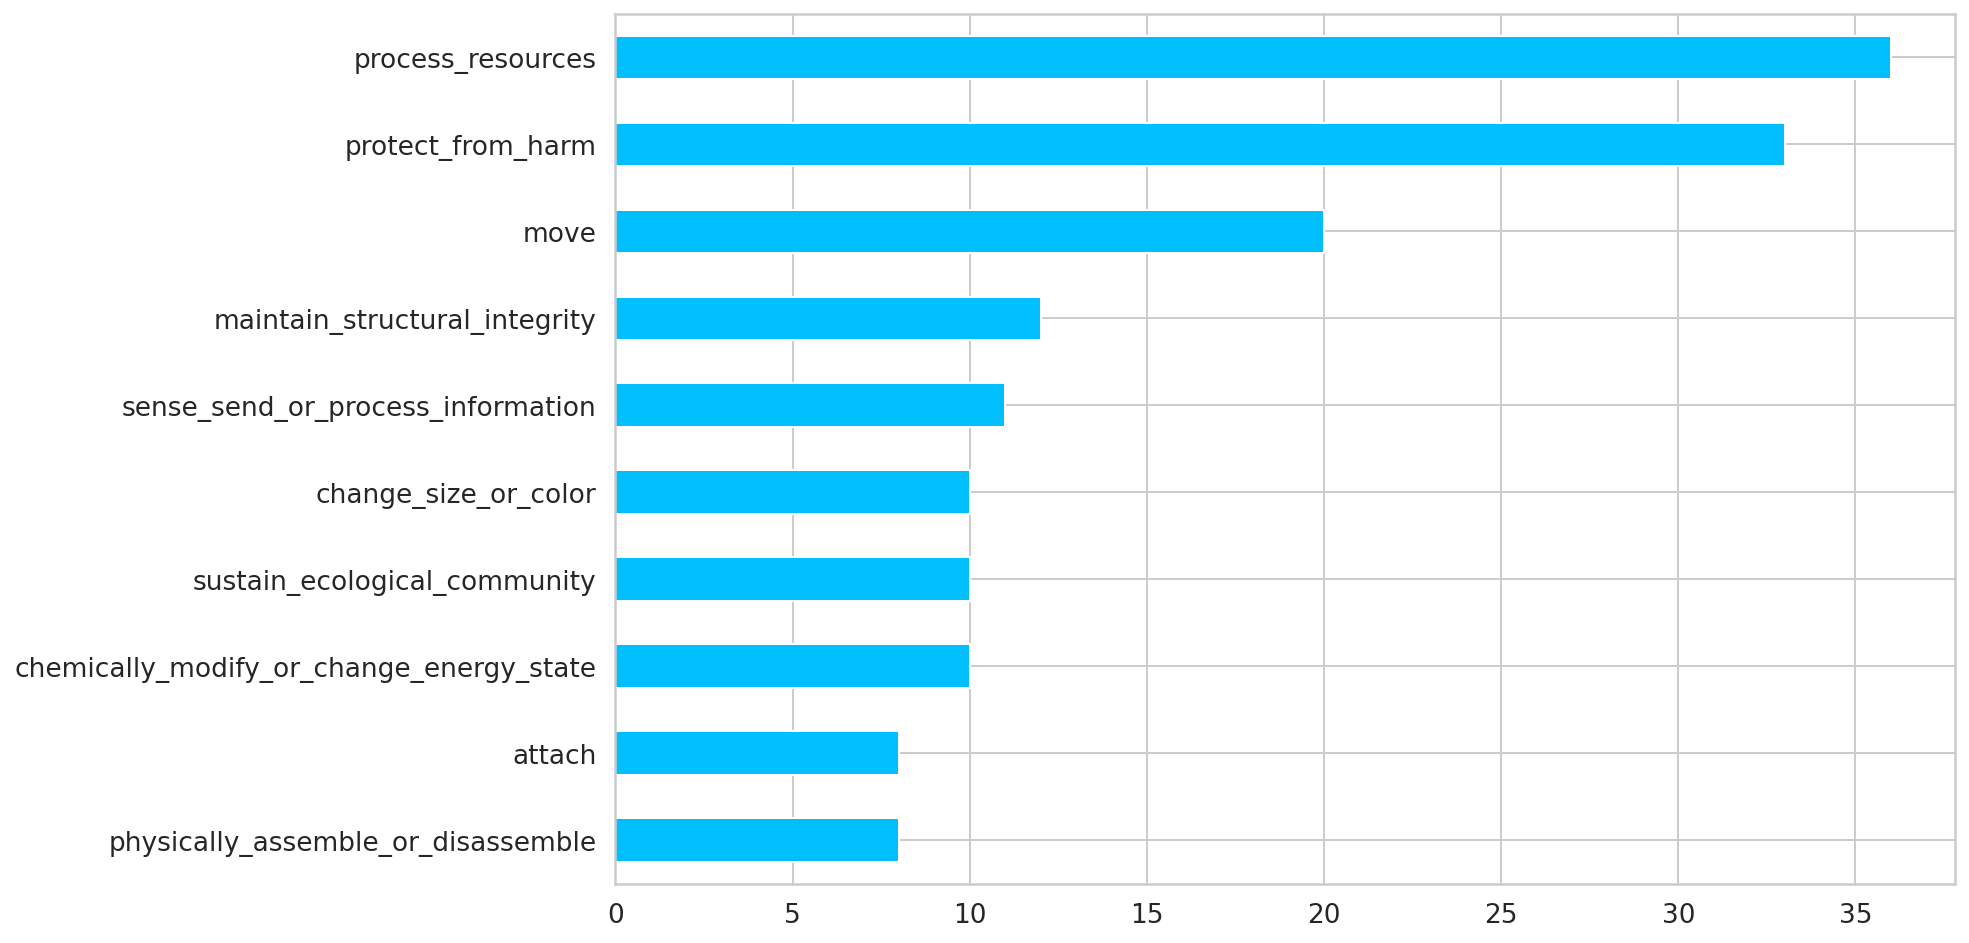

In [ ]:
val_df[LABEL_COLUMNS].sum().sort_values().plot(kind="barh");

### Tokenization

We need to convert the raw text into a list of tokens. For that, we'll use the built-in BertTokenizer:

In [ ]:
BERT_MODEL_NAME = 'allenai/scibert_scivocab_uncased'
tokenizer = BertTokenizer.from_pretrained(BERT_MODEL_NAME)

Downloading:   0%|          | 0.00/223k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/385 [00:00<?, ?B/s]

Let's try it out on a sample paper:

In [ ]:
sample_row = df.iloc[16]
sample_comment = sample_row.text_raw
sample_labels = sample_row[LABEL_COLUMNS]

print(sample_comment)
print()
print(sample_labels.to_dict())

Function of spiral grain in trees. SummaryThrough spiral grain, conduits for sap lead from each root to all branches. This uniform distribution of sap is indicated by the paths of vessels and tracheids, and has been proven experimentally by means of dyed sap injected into the base of stems or taken up by roots. Trees receiving water only from roots at one side of the root collar nevertheless stay green and continue growing. Spiral grain in bark distributes food from each branch to other flanks of the stem and to most roots. Experimental interruptions of the sap and food conduits caused the cambial zone to reorient new conduit cells in new directions, bypassing the interruption. In particular, spiral grooves cut into the stem surface caused spiral grain. The new cells reorient through division and growth. Although spiral grain is largely under genetic control, trees appear to have a spiral grain especially where needed for distribution of water when root spheres are dry at one side. Com

In [ ]:
encoding = tokenizer.encode_plus(
  sample_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [ ]:
encoding["input_ids"].shape, encoding["attention_mask"].shape

(torch.Size([1, 512]), torch.Size([1, 512]))

The result of the encoding is a dictionary with token ids `input_ids` and an attention mask `attention_mask` (which tokens should be used by the model 1 - use or 0 - don't use).

Let's look at their contents:

In [ ]:
encoding["input_ids"].squeeze()[:20]

tensor([  102,   662,   131, 15795,  9235,   121,  5606,   205,  4319,  9410,
        15795,  9235,   422,  6598,  5516,   168,  9254,  1269,   263,   535])

In [ ]:
encoding["attention_mask"].squeeze()[:20]

tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

You can also inverse the tokenization and get back (kinda) the words from the token ids:

In [ ]:
print(tokenizer.convert_ids_to_tokens(encoding["input_ids"].squeeze())[:20])

['[CLS]', 'function', 'of', 'spiral', 'grain', 'in', 'trees', '.', 'summary', '##through', 'spiral', 'grain', ',', 'cond', '##uits', 'for', 'sap', 'lead', 'from', 'each']


We need to specify the maximum number of tokens when encoding (512 is the maximum we can do). Let's check the number of tokens per paper:

In [ ]:
token_counts = []

for _, row in train_df.iterrows():
  token_count = len(tokenizer.encode(
    row["text_raw"], 
    max_length=512, 
    truncation=True
  ))
  token_counts.append(token_count)

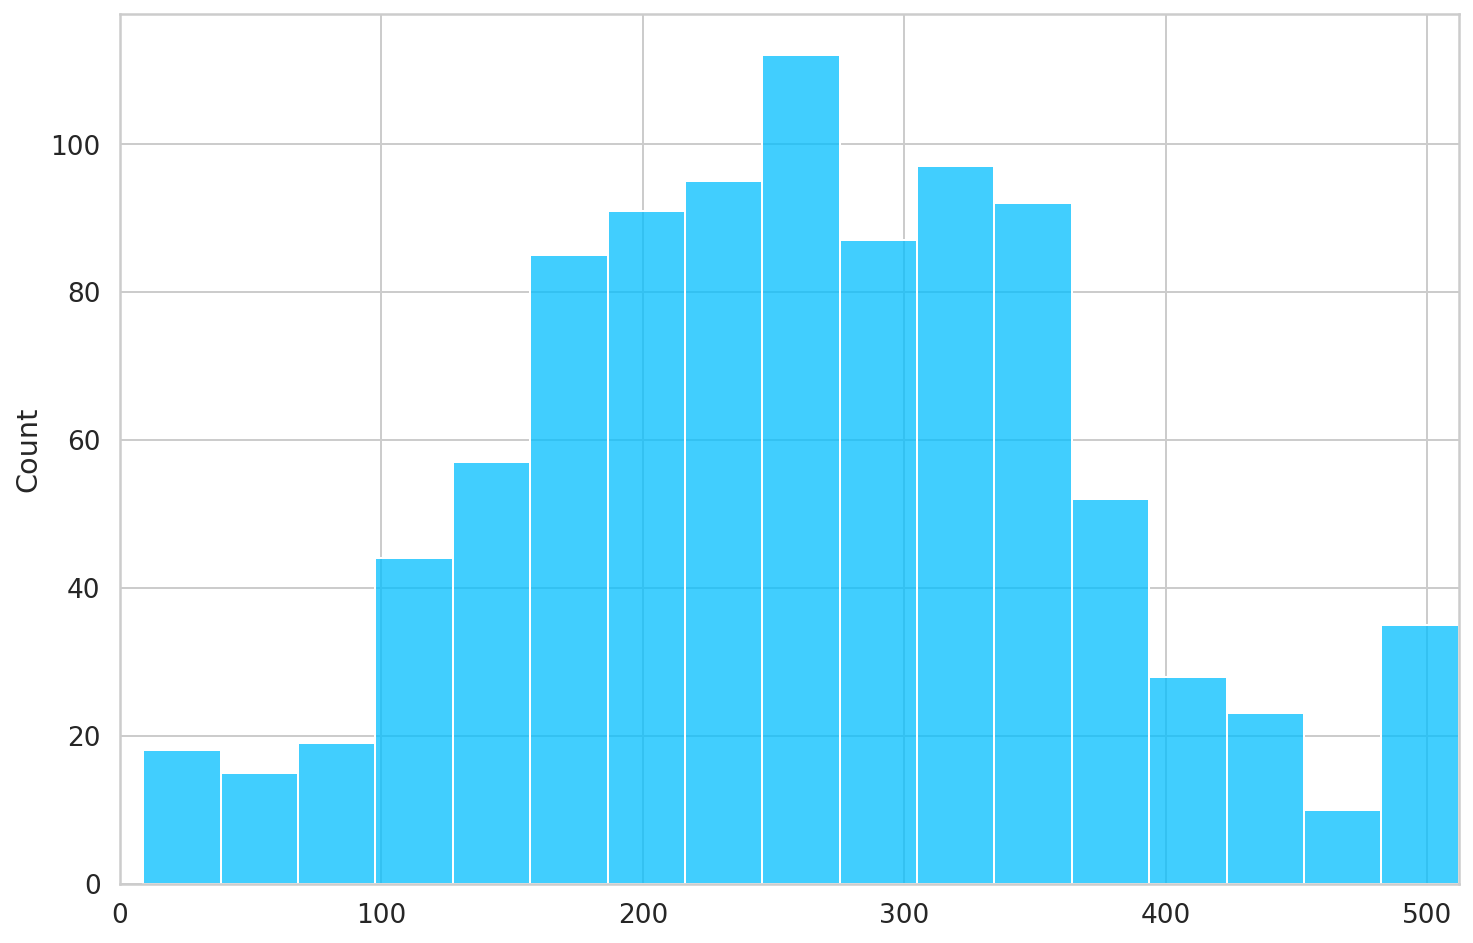

In [ ]:
sns.histplot(token_counts)
plt.xlim([0, 512]);

Most of the papers contain less than 400 tokens or more than 512. So, we'll stick with the limit of 512.

In [ ]:
MAX_TOKEN_COUNT = 256 #512 runs out of memory on colab

### Dataset

We'll wrap the tokenization process in a PyTorch Dataset, along with converting the labels to tensors:

In [ ]:
class BiomimicryDataset(Dataset):

  def __init__(
    self, 
    data: pd.DataFrame, 
    tokenizer: BertTokenizer, 
    max_token_len: int = 128
  ):
    self.tokenizer = tokenizer
    self.data = data
    self.max_token_len = max_token_len
    
  def __len__(self):
    return len(self.data)

  def __getitem__(self, index: int):
    data_row = self.data.iloc[index]

    text = data_row.text_raw
    labels = data_row[LABEL_COLUMNS]

    encoding = self.tokenizer.encode_plus(
      text,
      add_special_tokens=True,
      max_length=self.max_token_len,
      return_token_type_ids=False,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      return_tensors='pt',
    )

    return dict(
      text=text,
      input_ids=encoding["input_ids"].flatten(),
      attention_mask=encoding["attention_mask"].flatten(),
      labels=torch.FloatTensor(labels)
    )

Let's have a look at a sample item from the dataset:

In [ ]:
train_dataset = BiomimicryDataset(
  train_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

sample_item = train_dataset[0]
sample_item.keys()

dict_keys(['text', 'input_ids', 'attention_mask', 'labels'])

In [ ]:
sample_item["text"]

"Building a home from foam—túngara frog foam nest architecture and three-phase construction process. Frogs that build foam nests floating on water face the problems of over-dispersion of the secretions used and eggs being dangerously exposed at the foam : air interface. Nest construction behaviour of túngara frogs, Engystomops pustulosus, has features that may circumvent these problems. Pairs build nests in periodic bursts of foam production and egg deposition, three discrete phases being discernible. The first is characterized by a bubble raft without egg deposition and an approximately linear increase in duration of mixing events with time. This phase may reduce initial over-dispersion of foam precursor materials until a critical concentration is achieved. The main building phase is marked by mixing events and start-to-start intervals being nearly constant in duration. During the final phase, mixing events do not change in duration but intervals between them increase in an exponentia

In [ ]:
sample_item["labels"]

tensor([1., 1., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
sample_item["input_ids"].shape

torch.Size([256])

Let's load the BERT model and pass a sample of batch data through:

In [ ]:
bert_model = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)

Downloading:   0%|          | 0.00/422M [00:00<?, ?B/s]

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
sample_batch = next(iter(DataLoader(train_dataset, batch_size=8, num_workers=2)))
sample_batch["input_ids"].shape, sample_batch["attention_mask"].shape

(torch.Size([8, 256]), torch.Size([8, 256]))

In [ ]:
output = bert_model(sample_batch["input_ids"], sample_batch["attention_mask"])

In [ ]:
output.last_hidden_state.shape, output.pooler_output.shape

(torch.Size([8, 256, 768]), torch.Size([8, 768]))

The `768` dimension comes from the BERT hidden size:

In [ ]:
bert_model.config.hidden_size

768

The larger version of BERT has more attention heads and a larger hidden size.

We'll wrap our custom dataset into a [LightningDataModule](https://pytorch-lightning.readthedocs.io/en/stable/extensions/datamodules.html):

In [ ]:
class BiomimicryDataModule(pl.LightningDataModule):

  def __init__(self, train_df, test_df, tokenizer, batch_size=8, max_token_len=128):
    super().__init__()
    self.batch_size = batch_size
    self.train_df = train_df
    self.test_df = test_df
    self.tokenizer = tokenizer
    self.max_token_len = max_token_len

  def setup(self, stage=None):
    self.train_dataset = BiomimicryDataset(
      self.train_df,
      self.tokenizer,
      self.max_token_len
    )

    self.test_dataset = BiomimicryDataset(
      self.test_df,
      self.tokenizer,
      self.max_token_len
    )

  def train_dataloader(self):
    return DataLoader(
      self.train_dataset,
      batch_size=self.batch_size,
      shuffle=True,
      num_workers=2
    )

  def val_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

  def test_dataloader(self):
    return DataLoader(
      self.test_dataset,
      batch_size=self.batch_size,
      num_workers=2
    )

`BiomimicryDataModule` encapsulates all data loading logic and returns the necessary data loaders. Let's create an instance of our data module:

In [ ]:
N_EPOCHS = 10
BATCH_SIZE = 12

data_module = BiomimicryDataModule(
  train_df,
  val_df,
  tokenizer,
  batch_size=BATCH_SIZE,
  max_token_len=MAX_TOKEN_COUNT
)

## Model

Our model will use a pre-trained [BertModel](https://huggingface.co/transformers/model_doc/bert.html#bertmodel) and a linear layer to convert the BERT representation to a classification task. We'll pack everything in a [LightningModule](https://pytorch-lightning.readthedocs.io/en/stable/common/lightning_module.html):


In [ ]:
class BiomimicryTagger(pl.LightningModule):

  def __init__(self, n_classes: int, n_training_steps=None, n_warmup_steps=None):
    super().__init__()
    self.bert = BertModel.from_pretrained(BERT_MODEL_NAME, return_dict=True)
    self.classifier = nn.Linear(self.bert.config.hidden_size, n_classes)
    self.n_training_steps = n_training_steps
    self.n_warmup_steps = n_warmup_steps
    self.criterion = nn.BCELoss()

  def forward(self, input_ids, attention_mask, labels=None):
    output = self.bert(input_ids, attention_mask=attention_mask)
    output = self.classifier(output.pooler_output)
    output = torch.sigmoid(output)    
    loss = 0
    if labels is not None:
        loss = self.criterion(output, labels)
    return loss, output

  def training_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("train_loss", loss, prog_bar=True, logger=True)
    return {"loss": loss, "predictions": outputs, "labels": labels}

  def validation_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("val_loss", loss, prog_bar=True, logger=True)
    return loss

  def test_step(self, batch, batch_idx):
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    loss, outputs = self(input_ids, attention_mask, labels)
    self.log("test_loss", loss, prog_bar=True, logger=True)
    return loss

  def training_epoch_end(self, outputs):
    
    labels = []
    predictions = []
    for output in outputs:
      for out_labels in output["labels"].detach().cpu():
        labels.append(out_labels)
      for out_predictions in output["predictions"].detach().cpu():
        predictions.append(out_predictions)

    labels = torch.stack(labels).int()
    predictions = torch.stack(predictions)

    for i, name in enumerate(LABEL_COLUMNS):
      #class_roc_auc = auroc(predictions[:, i],  labels[:, i])
      class_ap = average_precision(predictions[:, i], labels[:, i])
      self.logger.experiment.add_scalar(f"{name}_ap/Train", class_ap, self.current_epoch)


  def configure_optimizers(self):

    optimizer = AdamW(self.parameters(), lr=2e-5)

    scheduler = get_linear_schedule_with_warmup(
      optimizer,
      num_warmup_steps=self.n_warmup_steps,
      num_training_steps=self.n_training_steps
    )

    return dict(
      optimizer=optimizer,
      lr_scheduler=dict(
        scheduler=scheduler,
        interval='step'
      )
    )

Most of the implementation is just a boilerplate. Two points of interest are the way we configure the optimizers and calculating the area under ROC. We'll dive a bit deeper into those next.

### Optimizer scheduler

The job of a scheduler is to change the learning rate of the optimizer during training. This might lead to better performance of our model. We'll use the [get_linear_schedule_with_warmup](https://huggingface.co/transformers/main_classes/optimizer_schedules.html#transformers.get_linear_schedule_with_warmup).

Let's have a look at a simple example to make things clearer:

In [ ]:
dummy_model = nn.Linear(2, 1)

optimizer = AdamW(params=dummy_model.parameters(), lr=0.001)

warmup_steps = 20
total_training_steps = 100

scheduler = get_linear_schedule_with_warmup(
  optimizer, 
  num_warmup_steps=warmup_steps,
  num_training_steps=total_training_steps
)

learning_rate_history = []

for step in range(total_training_steps):
  optimizer.step()
  scheduler.step()
  learning_rate_history.append(optimizer.param_groups[0]['lr'])

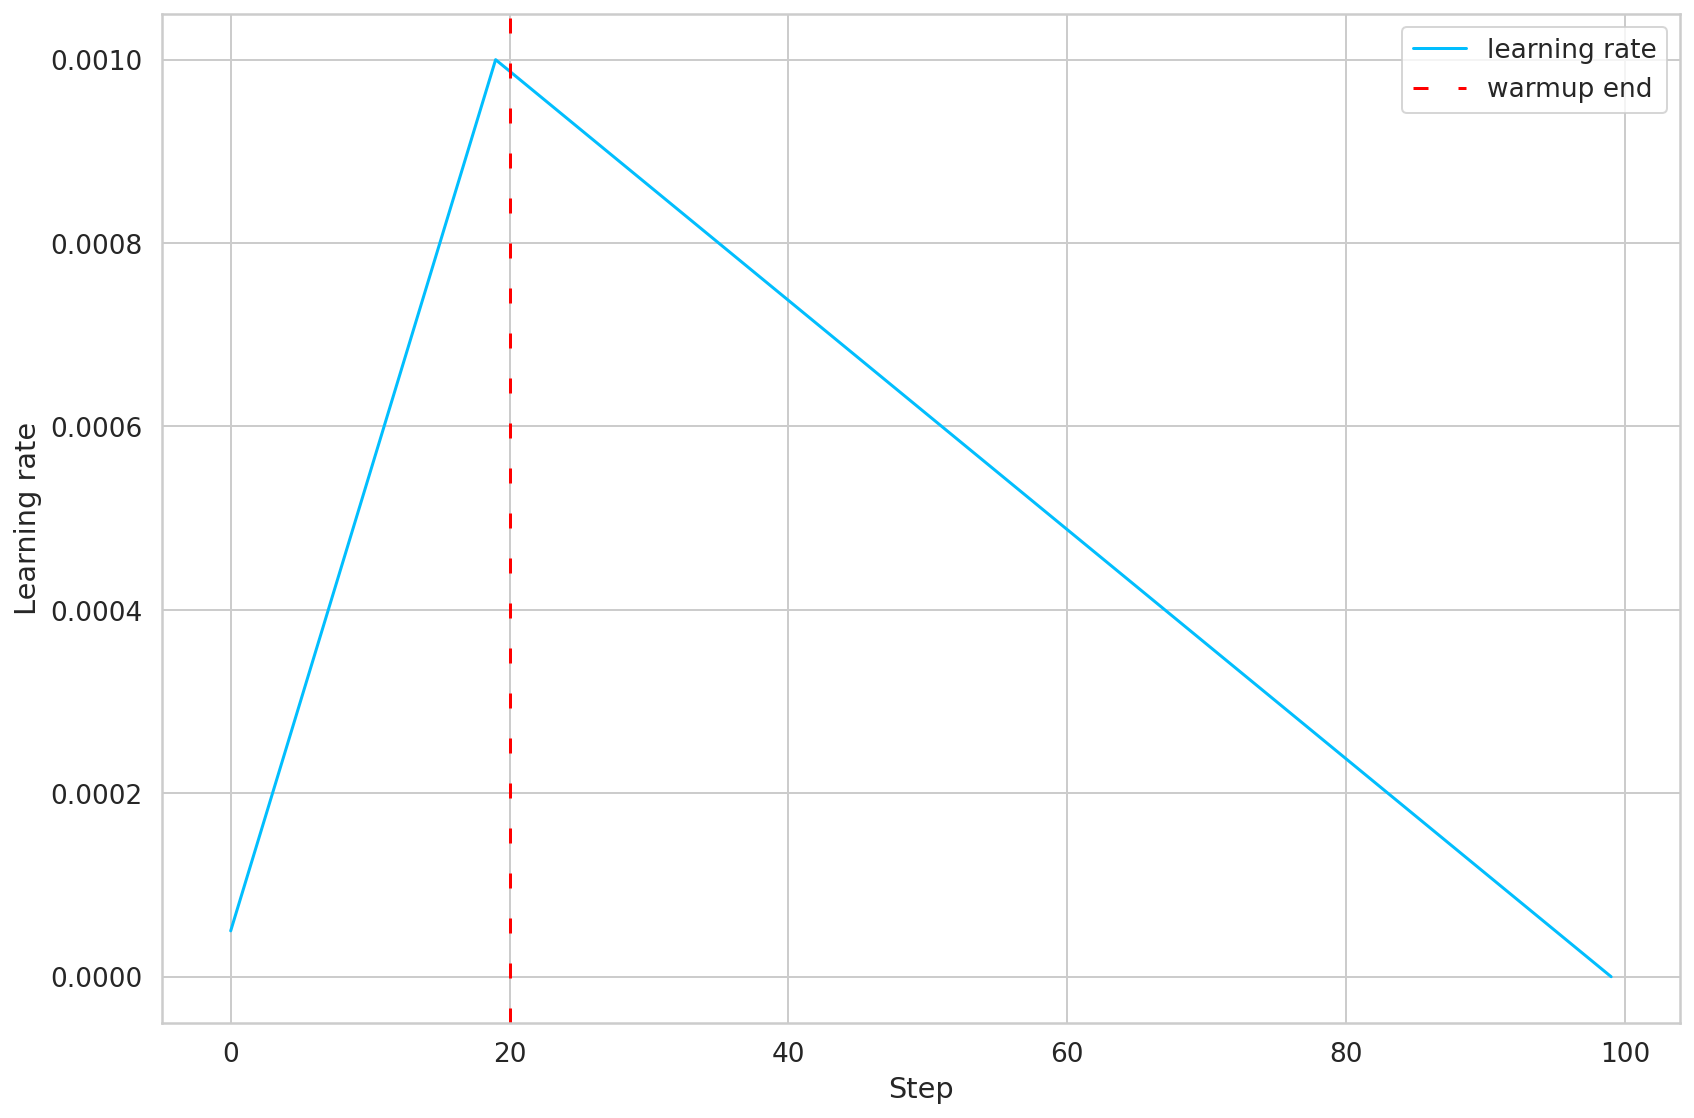

In [ ]:
plt.plot(learning_rate_history, label="learning rate")
plt.axvline(x=warmup_steps, color="red", linestyle=(0, (5, 10)), label="warmup end")
plt.legend()
plt.xlabel("Step")
plt.ylabel("Learning rate")
plt.tight_layout();

We simulate 100 training steps and tell the scheduler to warm up for the first 20. The learning rate grows to the initial fixed value of 0.001 during the warm-up and then goes down (linearly) to 0.

To use the scheduler, we need to calculate the number of training and warm-up steps. The number of training steps per epoch is equal to `number of training examples / batch size`. The number of total training steps is `training steps per epoch * number of epochs`:

In [ ]:
steps_per_epoch=len(train_df) // BATCH_SIZE
total_training_steps = steps_per_epoch * N_EPOCHS

We'll use a fifth of the training steps for a warm-up:

In [ ]:
warmup_steps = total_training_steps // 5
warmup_steps, total_training_steps

(160, 800)

We can now create an instance of our model:

In [ ]:
model = BiomimicryTagger(
  n_classes=len(LABEL_COLUMNS),
  n_warmup_steps=warmup_steps,
  n_training_steps=total_training_steps 
)

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


### Evaluation

Multi-label classification boils down to doing binary classification for each label/tag.

We'll use Binary Cross Entropy to measure the error for each label. PyTorch has [BCELoss](https://pytorch.org/docs/stable/generated/torch.nn.BCELoss.html), which we're going to combine with a sigmoid function (as we did in the model implementation). Let's look at an example:

In [ ]:
criterion = nn.BCELoss()

prediction = torch.FloatTensor(
  [10.95873564, 1.07321467, 1.58524066, 0.03839076, 15.72987556, 1.09513213, 1.58524066, 0.03839076, 15.72987556, 1.09513213]
)
labels = torch.FloatTensor(
  [1., 0., 0., 0., 1., 0., 0., 0., 1., 0.]
) 

In [ ]:
torch.sigmoid(prediction)

tensor([1.0000, 0.7452, 0.8299, 0.5096, 1.0000, 0.7493, 0.8299, 0.5096, 1.0000,
        0.7493])

In [ ]:
criterion(torch.sigmoid(prediction), labels)

tensor(0.9103)

We can use the same approach to calculate the loss of the predictions:

In [ ]:
_, predictions = model(sample_batch["input_ids"], sample_batch["attention_mask"])
predictions

tensor([[0.3892, 0.5270, 0.5594, 0.4966, 0.5627, 0.5172, 0.4708, 0.6627, 0.5501,
         0.5625],
        [0.4252, 0.5252, 0.6050, 0.4019, 0.6370, 0.5355, 0.5132, 0.6686, 0.5485,
         0.5394],
        [0.4149, 0.5026, 0.6056, 0.4327, 0.5293, 0.5151, 0.5167, 0.6715, 0.5513,
         0.4867],
        [0.3827, 0.5997, 0.5374, 0.4714, 0.5138, 0.5127, 0.4706, 0.6016, 0.5577,
         0.5578],
        [0.3897, 0.5470, 0.5240, 0.4497, 0.5921, 0.4998, 0.4722, 0.6885, 0.5460,
         0.5185],
        [0.4462, 0.6090, 0.5702, 0.5272, 0.5344, 0.5412, 0.3923, 0.6211, 0.5435,
         0.5295],
        [0.3698, 0.5668, 0.5845, 0.4256, 0.6110, 0.5358, 0.4524, 0.6373, 0.5693,
         0.5202],
        [0.4103, 0.5695, 0.5937, 0.4266, 0.6193, 0.5403, 0.4932, 0.6500, 0.6068,
         0.5756]], grad_fn=<SigmoidBackward0>)

In [ ]:
criterion(predictions, sample_batch["labels"])

tensor(0.7612, grad_fn=<BinaryCrossEntropyBackward0>)

#### ROC Curve

Another metric we're going to use is the area under the Receiver operating characteristic (ROC) for each tag. ROC is created by plotting the True Positive Rate (TPR) vs False Positive Rate (FPR):

$$
\text{TPR} = \frac{\text{TP}}{\text{TP} \text{+} \text{FN}}
$$

$$
\text{FPR} = \frac{\text{FP}}{\text{FP} \text{+} \text{TN}}
$$




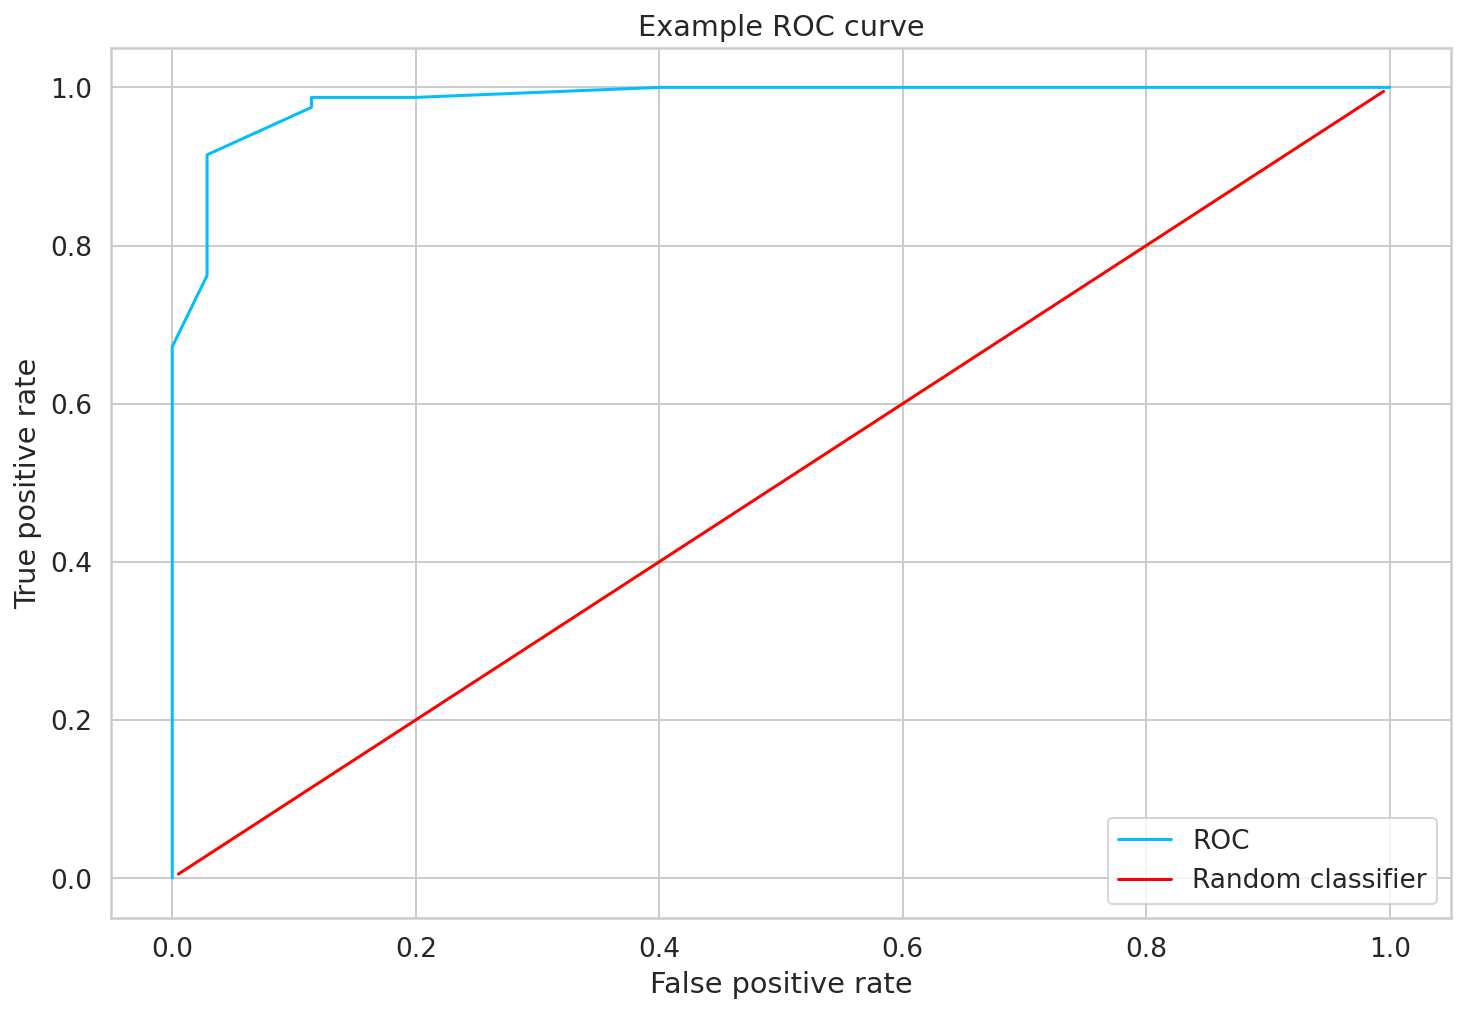

In [ ]:
from sklearn import metrics

fpr = [0.        , 0.        , 0.        , 0.02857143, 0.02857143,
       0.11428571, 0.11428571, 0.2       , 0.4       , 1.        ]

tpr = [0.        , 0.01265823, 0.67202532, 0.76202532, 0.91468354,
       0.97468354, 0.98734177, 0.98734177, 1.        , 1.        ]

_, ax = plt.subplots()
ax.plot(fpr, tpr, label="ROC")
ax.plot([0.05, 0.95], [0.05, 0.95], transform=ax.transAxes, label="Random classifier", color="red")
ax.legend(loc=4)
ax.set_xlabel("False positive rate")
ax.set_ylabel("True positive rate")
ax.set_title("Example ROC curve")
plt.show();

## Training

In [ ]:
!rm -rf lightning_logs/
!rm -rf checkpoints/

In [ ]:
%load_ext tensorboard
%tensorboard --logdir ./lightning_logs

<IPython.core.display.Javascript object>

The beauty of PyTorch Lightning is that you can build a standard pipeline that you like and train (almost?) every model you might imagine. I prefer to use at least 3 components.

Checkpointing that saves the best model (based on validation loss):

In [ ]:
checkpoint_callback = ModelCheckpoint(
  dirpath="checkpoints",
  filename="best-checkpoint",
  save_top_k=1,
  verbose=True,
  monitor="val_loss",
  mode="min"
)

Log the progress in TensorBoard:

In [ ]:
logger = TensorBoardLogger("lightning_logs", name="biomimicry-papers")

And early stopping triggers when the loss hasn't improved for the last 2 epochs (you might want to remove/reconsider this when training on real-world projects):

In [ ]:
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=2)

We can start the training process:

In [ ]:
trainer = pl.Trainer(
  logger=logger,
  checkpoint_callback=checkpoint_callback,
  callbacks=[early_stopping_callback],
  max_epochs=N_EPOCHS,
  gpus=1,
  progress_bar_refresh_rate=30
)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:148: LightningDeprecationWarning: Setting `Trainer(checkpoint_callback=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7faa51770290>)` is deprecated in v1.5 and will be removed in v1.7. Please consider using `Trainer(enable_checkpointing=<pytorch_lightning.callbacks.model_checkpoint.ModelCheckpoint object at 0x7faa51770290>)`.
  f"Setting `Trainer(checkpoint_callback={checkpoint_callback})` is deprecated in v1.5 and will "
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/connectors/callback_connector.py:91: LightningDeprecationWarning: Setting `Trainer(progress_bar_refresh_rate=30)` is deprecated in v1.5 and will be removed in v1.7. Please pass `pytorch_lightning.callbacks.progress.TQDMProgressBar` with `refresh_rate` directly to the Trainer's `callbacks` argument instead. Or, to disable the progress bar pass `enable_progress_bar = False` to the Tr

In [ ]:
trainer.fit(model, data_module)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type      | Params
-----------------------------------------
0 | bert       | BertModel | 109 M 
1 | classifier | Linear    | 7.7 K 
2 | criterion  | BCELoss   | 0     
-----------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
439.705   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1422. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1376. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
Global seed set to 42


Training: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/loops/optimization/closure.py:36: LightningDeprecationWarning: One of the returned values {'predictions', 'labels'} has a `grad_fn`. We will detach it automatically but this behaviour will change in v1.6. Please detach it manually: `return {'loss': ..., 'something': something.detach()}`
  f"One of the returned values {set(extra.keys())} has a `grad_fn`. We will detach it automatically"


Validating: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1475. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1995. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an ambiguous collection. The batch size we"
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/data.py:60: UserWarning: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 1806. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.
  "Trying to infer the `batch_size` from an 

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

The model improved for 8 epochs. We'll have to evaluate it to see whether it is any good. Let's double-check the validation loss:

In [ ]:
#trainer.test() #this generates an error for some reason.

## Predictions

I like to look at a small sample of predictions after the training is complete. This builds intuition about the quality of the predictions (qualitative evaluation).

Let's load the best version (according to the validation loss) of our model:

In [ ]:
trained_model = BiomimicryTagger.load_from_checkpoint(
  trainer.checkpoint_callback.best_model_path,
  n_classes=len(LABEL_COLUMNS)
)
trained_model.eval()
trained_model.freeze()

Some weights of the model checkpoint at allenai/scibert_scivocab_uncased were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


We put our model into "eval" mode, and we're ready to make some predictions. Here's the prediction on a sample paper:

In [ ]:
test_comment = "Cutin and Cutan Biopolymers: Their Role as Natural Sorbents. The aliphatic biopolymers cutin and cutan are important precursors of soil organic matter. In this study, we examined the effects of these biopolymers' decomposition and transformation in the soil on their sorptive properties. The levels of cutin and cutan decreased by 35 and 30%, respectively, after 20 mo of incubation. Carbon-13 nuclear magnetic resonance and differential scanning calorimeter analyses suggested that the rigid (crystalline) polymethylene moieties of cutan decompose with time. This observation is in contrast to previous reports, which suggested that this alkyl-C moiety is resistant to biodegradation. Cutin, however, exhibited mainly decomposition of the mobile (amorphous) polymethylene moieties. Moreover, some of its degraded materials were transformed into humic materials. The phenanthrene sorption coefficient decreased by 80 and 37% with incubation time of the cutin and cutan samples, respectively. For 1-naphthol, the sorption capacity decreased by 90% due to cutin decomposition. With cutan, this parameter did not show any changes correlated with incubation time. Phenanthrene exhibited linear and reversible sorption isotherms. In contrast, pronounced desorption hysteresis was obtained for 1-naphthol with the 20-mo-incubated cutin sample and with all cutan samples. With all cutan samples, desorption hysteresis increased with decomposition. Our data suggest that the sorptive nature of both biopolymers was affected by soil decomposition. With degradation, the role of cutin as a natural sorbent decreases while cutan acts as a natural highly efficient sorbent for organic compounds in the soil."

encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  print(f"{label}: {prediction}")

physically_assemble_or_disassemble: 0.022769546136260033
protect_from_harm: 0.0391952246427536
sense_send_or_process_information: 0.024146990850567818
chemically_modify_or_change_energy_state: 0.1336880773305893
maintain_structural_integrity: 0.08684246242046356
attach: 0.05097268894314766
move: 0.05782433599233627
process_resources: 0.7542394995689392
sustain_ecological_community: 0.054520368576049805
change_size_or_color: 0.02455037645995617


"process resources" followed by "chemically modify or change energy state". That seems like a great prediction! Let's look at another paper.





In [ ]:
THRESHOLD = 0.5

test_comment = "Molecular Mechanisms of Selenium Tolerance and Hyperaccumulation in Stanleya pinnata1. The molecular mechanisms responsible for selenium (Se) tolerance and hyperaccumulation were studied in the Se hyperaccumulator Stanleya pinnata (Brassicaceae) by comparing it with the related secondary Se accumulator Stanleya albescens using a combination of physiological, structural, genomic, and biochemical approaches. S. pinnata accumulated 3.6-fold more Se and was tolerant to 20 μm selenate, while S. albescens suffered reduced growth, chlorosis and necrosis, impaired photosynthesis, and high levels of reactive oxygen species. Levels of ascorbic acid, glutathione, total sulfur, and nonprotein thiols were higher in S. pinnata, suggesting that Se tolerance may in part be due to increased antioxidants and up-regulated sulfur assimilation. S. pinnata had higher selenocysteine methyltransferase protein levels and, judged from liquid chromatography-mass spectrometry, mainly accumulated the free amino acid methylselenocysteine, while S. albescens accumulated mainly the free amino acid selenocystathionine. S. albescens leaf x-ray absorption near-edge structure scans mainly detected a carbon-Se-carbon compound (presumably selenocystathionine) in addition to some selenocysteine and selenate. Thus, S. albescens may accumulate more toxic forms of Se in its leaves than S. pinnata. The species also showed different leaf Se sequestration patterns: while S. albescens showed a diffuse pattern, S. pinnata sequestered Se in localized epidermal cell clusters along leaf margins and tips, concentrated inside of epidermal cells. Transcript analyses of S. pinnata showed a constitutively higher expression of genes involved in sulfur assimilation, antioxidant activities, defense, and response to (methyl)jasmonic acid, salicylic acid, or ethylene. The levels of some of these hormones were constitutively elevated in S. pinnata compared with S. albescens, and leaf Se accumulation was slightly enhanced in both species when these hormones were supplied. Thus, defense-related phytohormones may play an important signaling role in the Se hyperaccumulation of S. pinnata, perhaps by constitutively up-regulating sulfur/Se assimilation followed by methylation of selenocysteine and the targeted sequestration of methylselenocysteine."

encoding = tokenizer.encode_plus(
  test_comment,
  add_special_tokens=True,
  max_length=512,
  return_token_type_ids=False,
  padding="max_length",
  return_attention_mask=True,
  return_tensors='pt',
)

_, test_prediction = trained_model(encoding["input_ids"], encoding["attention_mask"])
test_prediction = test_prediction.flatten().numpy()

for label, prediction in zip(LABEL_COLUMNS, test_prediction):
  if prediction < THRESHOLD:
    continue
  print(f"{label}: {prediction}")

protect_from_harm: 0.7669231295585632


Since the paper mentions defense, this seems like a reasonable prediction.

## Evaluation

Let's get a more complete overview of the performance of our model. We'll start by taking all predictions and labels from the validation set:

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
trained_model = trained_model.to(device)

val_dataset = BiomimicryDataset(
  val_df,
  tokenizer,
  max_token_len=MAX_TOKEN_COUNT
)

predictions = []
labels = []

for item in tqdm(val_dataset):
  _, prediction = trained_model(
    item["input_ids"].unsqueeze(dim=0).to(device), 
    item["attention_mask"].unsqueeze(dim=0).to(device)
  )
  predictions.append(prediction.flatten())
  labels.append(item["labels"].int())

predictions = torch.stack(predictions).detach().cpu()
labels = torch.stack(labels).detach().cpu()

  0%|          | 0/107 [00:00<?, ?it/s]

One simple metric is the accuracy of the model:

In [ ]:
accuracy(predictions, labels, threshold=THRESHOLD)

tensor(0.8981)

That's great, but you should take this result with a grain of salt. We have a very imbalanced dataset. Let's check the ROC for each tag:

In [ ]:
print("AUROC per tag")

tag_rocs = []

for i, name in enumerate(LABEL_COLUMNS):
  tag_auroc = auroc(predictions[:, i], labels[:, i], pos_label=1)
  if not torch.isnan(tag_auroc).item():
    tag_rocs.append(tag_auroc)
  print(f"{name}: {tag_auroc}")

mean_auroc = torch.mean(torch.stack(tag_rocs))
print("Mean AUROC: ", mean_auroc)

AUROC per tag
physically_assemble_or_disassemble: 0.8106061220169067
protect_from_harm: 0.7813267707824707
sense_send_or_process_information: 0.9299241900444031
chemically_modify_or_change_energy_state: 0.8690721988677979
maintain_structural_integrity: 0.9140350818634033
attach: 0.9090909361839294
move: 0.842528760433197
process_resources: 0.8325508832931519
sustain_ecological_community: 0.9453607797622681
change_size_or_color: 0.8463916778564453
Mean AUROC:  tensor(0.8681)


Very good results, but just before we go party, let's check the classification report for each class. To make this work, we must apply thresholding to the predictions:

In [ ]:
y_pred = predictions.numpy()
y_true = labels.numpy()

upper, lower = 1, 0

y_pred = np.where(y_pred > THRESHOLD, upper, lower)

print(classification_report(
  y_true, 
  y_pred, 
  target_names=LABEL_COLUMNS, 
  zero_division=0
))

                                          precision    recall  f1-score   support

      physically_assemble_or_disassemble       1.00      0.25      0.40         8
                       protect_from_harm       0.53      0.48      0.51        33
       sense_send_or_process_information       0.86      0.55      0.67        11
chemically_modify_or_change_energy_state       0.86      0.60      0.71        10
           maintain_structural_integrity       0.57      0.67      0.62        12
                                  attach       0.62      0.62      0.62         8
                                    move       0.92      0.55      0.69        20
                       process_resources       0.80      0.56      0.66        36
            sustain_ecological_community       0.64      0.70      0.67        10
                    change_size_or_color       0.71      0.50      0.59        10

                               micro avg       0.70      0.54      0.61       158
              

That gives us a much more realistic picture of the overall performance. Next let's take a look at Average Precision by tag. This will show us how the system ranked papers in each tag, compared with the ideal ranking.

In [ ]:
print("AP per tag")

tag_aps = []

for i, name in enumerate(LABEL_COLUMNS):
  tag_ap = average_precision(predictions[:, i], labels[:, i], pos_label=1)
  if not torch.isnan(tag_ap).item():
    tag_aps.append(tag_ap)
  print(f"{name}: {tag_ap}")

#map = map / len(LABEL_COLUMNS)

map = torch.mean(torch.stack(tag_aps))

def gmean(input_x, dim=0):
    log_x = torch.log(input_x)
    return torch.exp(torch.mean(log_x, dim=dim))

gmap = gmean(torch.stack(tag_aps))

print("MAP: ", map)
print("gMAP: ", gmap)

AP per tag
physically_assemble_or_disassemble: 0.4674225151538849
protect_from_harm: 0.5822509527206421
sense_send_or_process_information: 0.7612271308898926
chemically_modify_or_change_energy_state: 0.6756001710891724
maintain_structural_integrity: 0.6118372082710266
attach: 0.7642350792884827
move: 0.7826091051101685
process_resources: 0.7186270356178284
sustain_ecological_community: 0.6470338106155396
change_size_or_color: 0.6696577668190002
MAP:  tensor(0.6681)
gMAP:  tensor(0.6611)


## References

- [Toxic comments EDA](https://www.kaggle.com/swathi314/toxic-comment-classification-eda)
- [Receiver operating characteristic on ML crash course](https://developers.google.com/machine-learning/crash-course/classification/roc-and-auc)